In [566]:
import math
import torch
import time
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import Tensor
from scipy.special import gamma 
import matplotlib.pyplot as plt

In [567]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
custom_params = {
    'font.size': 20,
    'lines.linewidth': 1,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
}

In [568]:
def get_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated()/ (1024*1024)
    return 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Fractional_Order_Matrix_Differential_Solver(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha,k,epoch):
        alpha = torch.tensor(alpha)
        k = torch.tensor(k)
        epoch = torch.tensor(epoch)
        ctx.save_for_backward(input1,w,b,alpha,k,epoch)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha,k,epoch = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver.Fractional_Order_Matrix_Differential_Linear(input1,w,b,alpha,k,epoch)   
        x_grad = torch.mm(grad_outputs,x_fractional)
        w_grad = torch.mm(w_fractional,grad_outputs)
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None,None,None

    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear(x,w,b,alpha,k,epoch):
        #w
        wf = w[:,0].view(1,-1)
        #main
        w_main = torch.mul(x,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        x_rows, x_cols = x.size()
        bias = torch.full((x_rows, x_cols),b[0].item())
        bias = bias.to(device)
        w_partial = torch.mul(torch.mm(x,wf.T).view(-1,1).expand(-1,x_cols) - torch.mul(x,wf) + bias, torch.sign(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return w.T, (w_main + torch.exp(-k*epoch)*w_partial).T

class FLinear(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, k = 0.9, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.k = k

        self.weight = Parameter(torch.empty((in_features, out_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x, epoch):
        return Fractional_Order_Matrix_Differential_Solver.apply(x, self.weight, self.bias, self.alpha, self.k, epoch)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"
    
def split(X,y):
    X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3,shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333,shuffle=False)
    return X_train,X_val,X_test,y_train,y_val,y_test

#Mean Square Error
def MSE(pred,true):
    return np.mean((pred-true)**2)

#Mean Absolute Error
def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def RMSE(pred,true):
    return np.sqrt(np.mean((pred-true)**2))


In [451]:
slide_windows_size = 192  #i.e.,input length 192
pred_length = 384     #i.e.,prediction lengths 384
stock = 'DJI'    #ETTh2,DJI
df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
# del df_DJIA['date']        #ETT2
del df_DJIA['Date']        #DJI
scaler = MinMaxScaler(feature_range=(0, 1))

sca_DJIA = scaler.fit_transform(df_DJIA)

features_j = 4     #ETTh2:6,DJI:4
def create_sequences(data, slide_windows_size, pred_length):
    X, y = [], []
    for i in range(len(data) - slide_windows_size - pred_length + 1):
        X.append(data[i:i+slide_windows_size, :])  # sliding window size [seq_len, features]
        y.append(data[i+slide_windows_size:i+slide_windows_size+pred_length, features_j])  
    return np.array(X), np.array(y)

X, y = create_sequences(sca_DJIA, slide_windows_size, pred_length)
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)

X_train,X_val,X_test,y_train,y_val,y_test = split(X,y)   #7:2:1 

In [ ]:
alpha = 1.0   ####0.7,0.8,0.9,1.0
k = 0.01    
batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   ###DJI:hidden_size=256,ETTh1:hidden_size=128.
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha, k)     
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha, k) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha, k)   

    def forward(self, x, epoch=0):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x, epoch)) 
        x = self.leakrelu2(self.linear2(x, epoch))
        x = self.linear3(x, epoch)
        return x



num_feature = 5     #ETTh1:7,DJI:5

set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss10 = []    ###
val_loss10 = []      ###

lr =4e-2  
num_epochs = 500   #1500
best_loss = 10
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#time_start = time.time()
#initial_allocated = get_memory_usage()
for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs,ii)
        loss = criterion(outputs, targets)
        loss_sum += loss
        #loss.backward(retain_graph=True)     #The default value of retain_graph is False. only for the first time, to calculate the Memory usage.
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    final_allocated = get_memory_usage() 
    time_end = time.time()
    #print(f"Final allocated memory: {(final_allocated-initial_allocated):.4f} MB")   
    #print(f"Training time: {(time_end-time_start):.4f}s")
    train_loss10.append(loss_sum.cpu().detach().numpy())     ###########
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss10.append(MSE_val)   ########################Validation_loss
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')
        if best_loss > MSE_val:
            best_loss = MSE_val
            torch.save(model.state_dict(), r'./model/fig5/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth')   

Epoch 1/500, Train Loss: 0.6923
Epoch 1/500, Val Loss: 0.3599

Epoch 2/500, Train Loss: 0.6796
Epoch 2/500, Val Loss: 0.3564

Epoch 3/500, Train Loss: 0.6702
Epoch 3/500, Val Loss: 0.3531

Epoch 4/500, Train Loss: 0.6613
Epoch 4/500, Val Loss: 0.3499

Epoch 5/500, Train Loss: 0.6540
Epoch 5/500, Val Loss: 0.3468

Epoch 6/500, Train Loss: 0.6448
Epoch 6/500, Val Loss: 0.3438

Epoch 7/500, Train Loss: 0.6368
Epoch 7/500, Val Loss: 0.3407

Epoch 8/500, Train Loss: 0.6291
Epoch 8/500, Val Loss: 0.3376

Epoch 9/500, Train Loss: 0.6207
Epoch 9/500, Val Loss: 0.3345

Epoch 10/500, Train Loss: 0.6122
Epoch 10/500, Val Loss: 0.3313

Epoch 11/500, Train Loss: 0.6040
Epoch 11/500, Val Loss: 0.3280

Epoch 12/500, Train Loss: 0.5952
Epoch 12/500, Val Loss: 0.3245

Epoch 13/500, Train Loss: 0.5860
Epoch 13/500, Val Loss: 0.3210

Epoch 14/500, Train Loss: 0.5764
Epoch 14/500, Val Loss: 0.3172

Epoch 15/500, Train Loss: 0.5691
Epoch 15/500, Val Loss: 0.3133

Epoch 16/500, Train Loss: 0.5596
Epoch 16/5

In [528]:
alpha = 0.9   ####0.7,0.8,0.9,1.0
# k = 0.01
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   ###DJI:hidden_size=256,ETTh1:hidden_size=128.
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha, k)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha, k) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha, k)       
        #self.linear2 = nn.Linear(hidden_size, output_size)                                 #To calculate the Memory usage on SGD.

    def forward(self, x, epoch=0):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x, epoch))  
        x = self.leakrelu2(self.linear2(x, epoch))
        x = self.linear3(x, epoch)
        return x



# num_feature = 5      #ETTh1:7,DJI:5

set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss09 = []    ###
val_loss09 = []      ###

# lr =1e-2  
# num_epochs = 500   #1500
best_loss = 10
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#time_start = time.time()
#initial_allocated = get_memory_usage()
for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs,ii)
        loss = criterion(outputs, targets)
        loss_sum += loss
        #loss.backward(retain_graph=True)     #The default value of retain_graph is False. only for the first time, to calculate the Memory usage.
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    final_allocated = get_memory_usage() 
    time_end = time.time()
    #print(f"Final allocated memory: {(final_allocated-initial_allocated):.4f} MB")   
    #print(f"Training time: {(time_end-time_start):.4f}s")
    train_loss09.append(loss_sum.cpu().detach().numpy())     ###########
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss09.append(MSE_val)   ########################Validation_loss
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')
        if best_loss > MSE_val:
            best_loss = MSE_val
            torch.save(model.state_dict(), r'./model/fig5/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth')   

Epoch 1/500, Train Loss: 0.6920
Epoch 1/500, Val Loss: 0.3592

Epoch 2/500, Train Loss: 0.6787
Epoch 2/500, Val Loss: 0.3565

Epoch 3/500, Train Loss: 0.6706
Epoch 3/500, Val Loss: 0.3538

Epoch 4/500, Train Loss: 0.6635
Epoch 4/500, Val Loss: 0.3516

Epoch 5/500, Train Loss: 0.6581
Epoch 5/500, Val Loss: 0.3499

Epoch 6/500, Train Loss: 0.6479
Epoch 6/500, Val Loss: 0.3458

Epoch 7/500, Train Loss: 0.6380
Epoch 7/500, Val Loss: 0.3425

Epoch 8/500, Train Loss: 0.6299
Epoch 8/500, Val Loss: 0.3392

Epoch 9/500, Train Loss: 0.6211
Epoch 9/500, Val Loss: 0.3357

Epoch 10/500, Train Loss: 0.6121
Epoch 10/500, Val Loss: 0.3323

Epoch 11/500, Train Loss: 0.6028
Epoch 11/500, Val Loss: 0.3285

Epoch 12/500, Train Loss: 0.5982
Epoch 12/500, Val Loss: 0.3295

Epoch 13/500, Train Loss: 0.5923
Epoch 13/500, Val Loss: 0.3259

Epoch 14/500, Train Loss: 0.5813
Epoch 14/500, Val Loss: 0.3217

Epoch 15/500, Train Loss: 0.5728
Epoch 15/500, Val Loss: 0.3168

Epoch 16/500, Train Loss: 0.5625
Epoch 16/5

In [529]:
alpha = 0.8   ####0.7,0.8,0.9,1.0
# k = 0.01
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   ###DJI:hidden_size=256,ETTh1:hidden_size=128.
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha, k)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha, k) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha, k)       
        #self.linear2 = nn.Linear(hidden_size, output_size)                                 #To calculate the Memory usage on SGD.

    def forward(self, x, epoch=0):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x, epoch))  
        x = self.leakrelu2(self.linear2(x, epoch))
        x = self.linear3(x, epoch)
        return x



# num_feature = 5      #ETTh1:7,DJI:5

set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss08 = []    ###
val_loss08 = []      ###

# lr =1e-2  
# num_epochs = 500   #1500
best_loss = 10
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#time_start = time.time()
#initial_allocated = get_memory_usage()
for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs,ii)
        loss = criterion(outputs, targets)
        loss_sum += loss
        #loss.backward(retain_graph=True)     #The default value of retain_graph is False. only for the first time, to calculate the Memory usage.
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    final_allocated = get_memory_usage() 
    time_end = time.time()
    #print(f"Final allocated memory: {(final_allocated-initial_allocated):.4f} MB")   
    #print(f"Training time: {(time_end-time_start):.4f}s")
    train_loss08.append(loss_sum.cpu().detach().numpy())     ###########
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss08.append(MSE_val)   ########################Validation_loss
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')
        if best_loss > MSE_val:
            best_loss = MSE_val
            torch.save(model.state_dict(), r'./model/fig5/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth')     

Epoch 1/500, Train Loss: 0.6940
Epoch 1/500, Val Loss: 0.3630

Epoch 2/500, Train Loss: 0.6856
Epoch 2/500, Val Loss: 0.3610

Epoch 3/500, Train Loss: 0.6789
Epoch 3/500, Val Loss: 0.3596

Epoch 4/500, Train Loss: 0.6728
Epoch 4/500, Val Loss: 0.3568

Epoch 5/500, Train Loss: 0.6756
Epoch 5/500, Val Loss: 0.3623

Epoch 6/500, Train Loss: 0.6822
Epoch 6/500, Val Loss: 0.3584

Epoch 7/500, Train Loss: 0.6701
Epoch 7/500, Val Loss: 0.3524

Epoch 8/500, Train Loss: 0.6575
Epoch 8/500, Val Loss: 0.3486

Epoch 9/500, Train Loss: 0.6420
Epoch 9/500, Val Loss: 0.3436

Epoch 10/500, Train Loss: 0.6335
Epoch 10/500, Val Loss: 0.3396

Epoch 11/500, Train Loss: 0.6114
Epoch 11/500, Val Loss: 0.3287

Epoch 12/500, Train Loss: 0.5926
Epoch 12/500, Val Loss: 0.3206

Epoch 13/500, Train Loss: 0.5756
Epoch 13/500, Val Loss: 0.3140

Epoch 14/500, Train Loss: 0.5583
Epoch 14/500, Val Loss: 0.3064

Epoch 15/500, Train Loss: 0.5427
Epoch 15/500, Val Loss: 0.2974

Epoch 16/500, Train Loss: 0.5228
Epoch 16/5

In [530]:
alpha = 0.7   ####0.7,0.8,0.9,1.0
# k = 0.01
# batch_size = 256
set_seed()
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128,output_size=pred_length):   ###DJI:hidden_size=256,ETTh1:hidden_size=128.
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha, k)       
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha, k) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha, k)       
        #self.linear2 = nn.Linear(hidden_size, output_size)                                 #To calculate the Memory usage on SGD.

    def forward(self, x, epoch=0):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x, epoch))  
        x = self.leakrelu2(self.linear2(x, epoch))
        x = self.linear3(x, epoch)
        return x



# num_feature = 5      #ETTh1:7,DJI:5

set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss07 = []    ###
val_loss07 = []      ###

# lr =1e-2  
# num_epochs = 500   #1500
best_loss = 10
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#time_start = time.time()
#initial_allocated = get_memory_usage()
for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs,ii)
        loss = criterion(outputs, targets)
        loss_sum += loss
        #loss.backward(retain_graph=True)     #The default value of retain_graph is False. only for the first time, to calculate the Memory usage.
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    final_allocated = get_memory_usage() 
    time_end = time.time()
    #print(f"Final allocated memory: {(final_allocated-initial_allocated):.4f} MB")   
    #print(f"Training time: {(time_end-time_start):.4f}s")
    train_loss07.append(loss_sum.cpu().detach().numpy())     ###########
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val)
        MSE_val = MSE(y_val.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss07.append(MSE_val)   ########################Validation_loss
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')
        if best_loss > MSE_val:
            best_loss = MSE_val
            torch.save(model.state_dict(), r'./model/fig5/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth')      

Epoch 1/500, Train Loss: 0.6943
Epoch 1/500, Val Loss: 0.3622

Epoch 2/500, Train Loss: 0.6856
Epoch 2/500, Val Loss: 0.3610

Epoch 3/500, Train Loss: 0.6803
Epoch 3/500, Val Loss: 0.3593

Epoch 4/500, Train Loss: 0.6755
Epoch 4/500, Val Loss: 0.3588

Epoch 5/500, Train Loss: 0.6719
Epoch 5/500, Val Loss: 0.3565

Epoch 6/500, Train Loss: 0.6634
Epoch 6/500, Val Loss: 0.3550

Epoch 7/500, Train Loss: 0.6574
Epoch 7/500, Val Loss: 0.3530

Epoch 8/500, Train Loss: 0.6519
Epoch 8/500, Val Loss: 0.3511

Epoch 9/500, Train Loss: 0.6450
Epoch 9/500, Val Loss: 0.3490

Epoch 10/500, Train Loss: 0.6375
Epoch 10/500, Val Loss: 0.3450

Epoch 11/500, Train Loss: 0.6298
Epoch 11/500, Val Loss: 0.3491

Epoch 12/500, Train Loss: 0.6345
Epoch 12/500, Val Loss: 0.3463

Epoch 13/500, Train Loss: 0.6259
Epoch 13/500, Val Loss: 0.3392

Epoch 14/500, Train Loss: 0.6042
Epoch 14/500, Val Loss: 0.3343

Epoch 15/500, Train Loss: 0.5946
Epoch 15/500, Val Loss: 0.3289

Epoch 16/500, Train Loss: 0.5830
Epoch 16/5

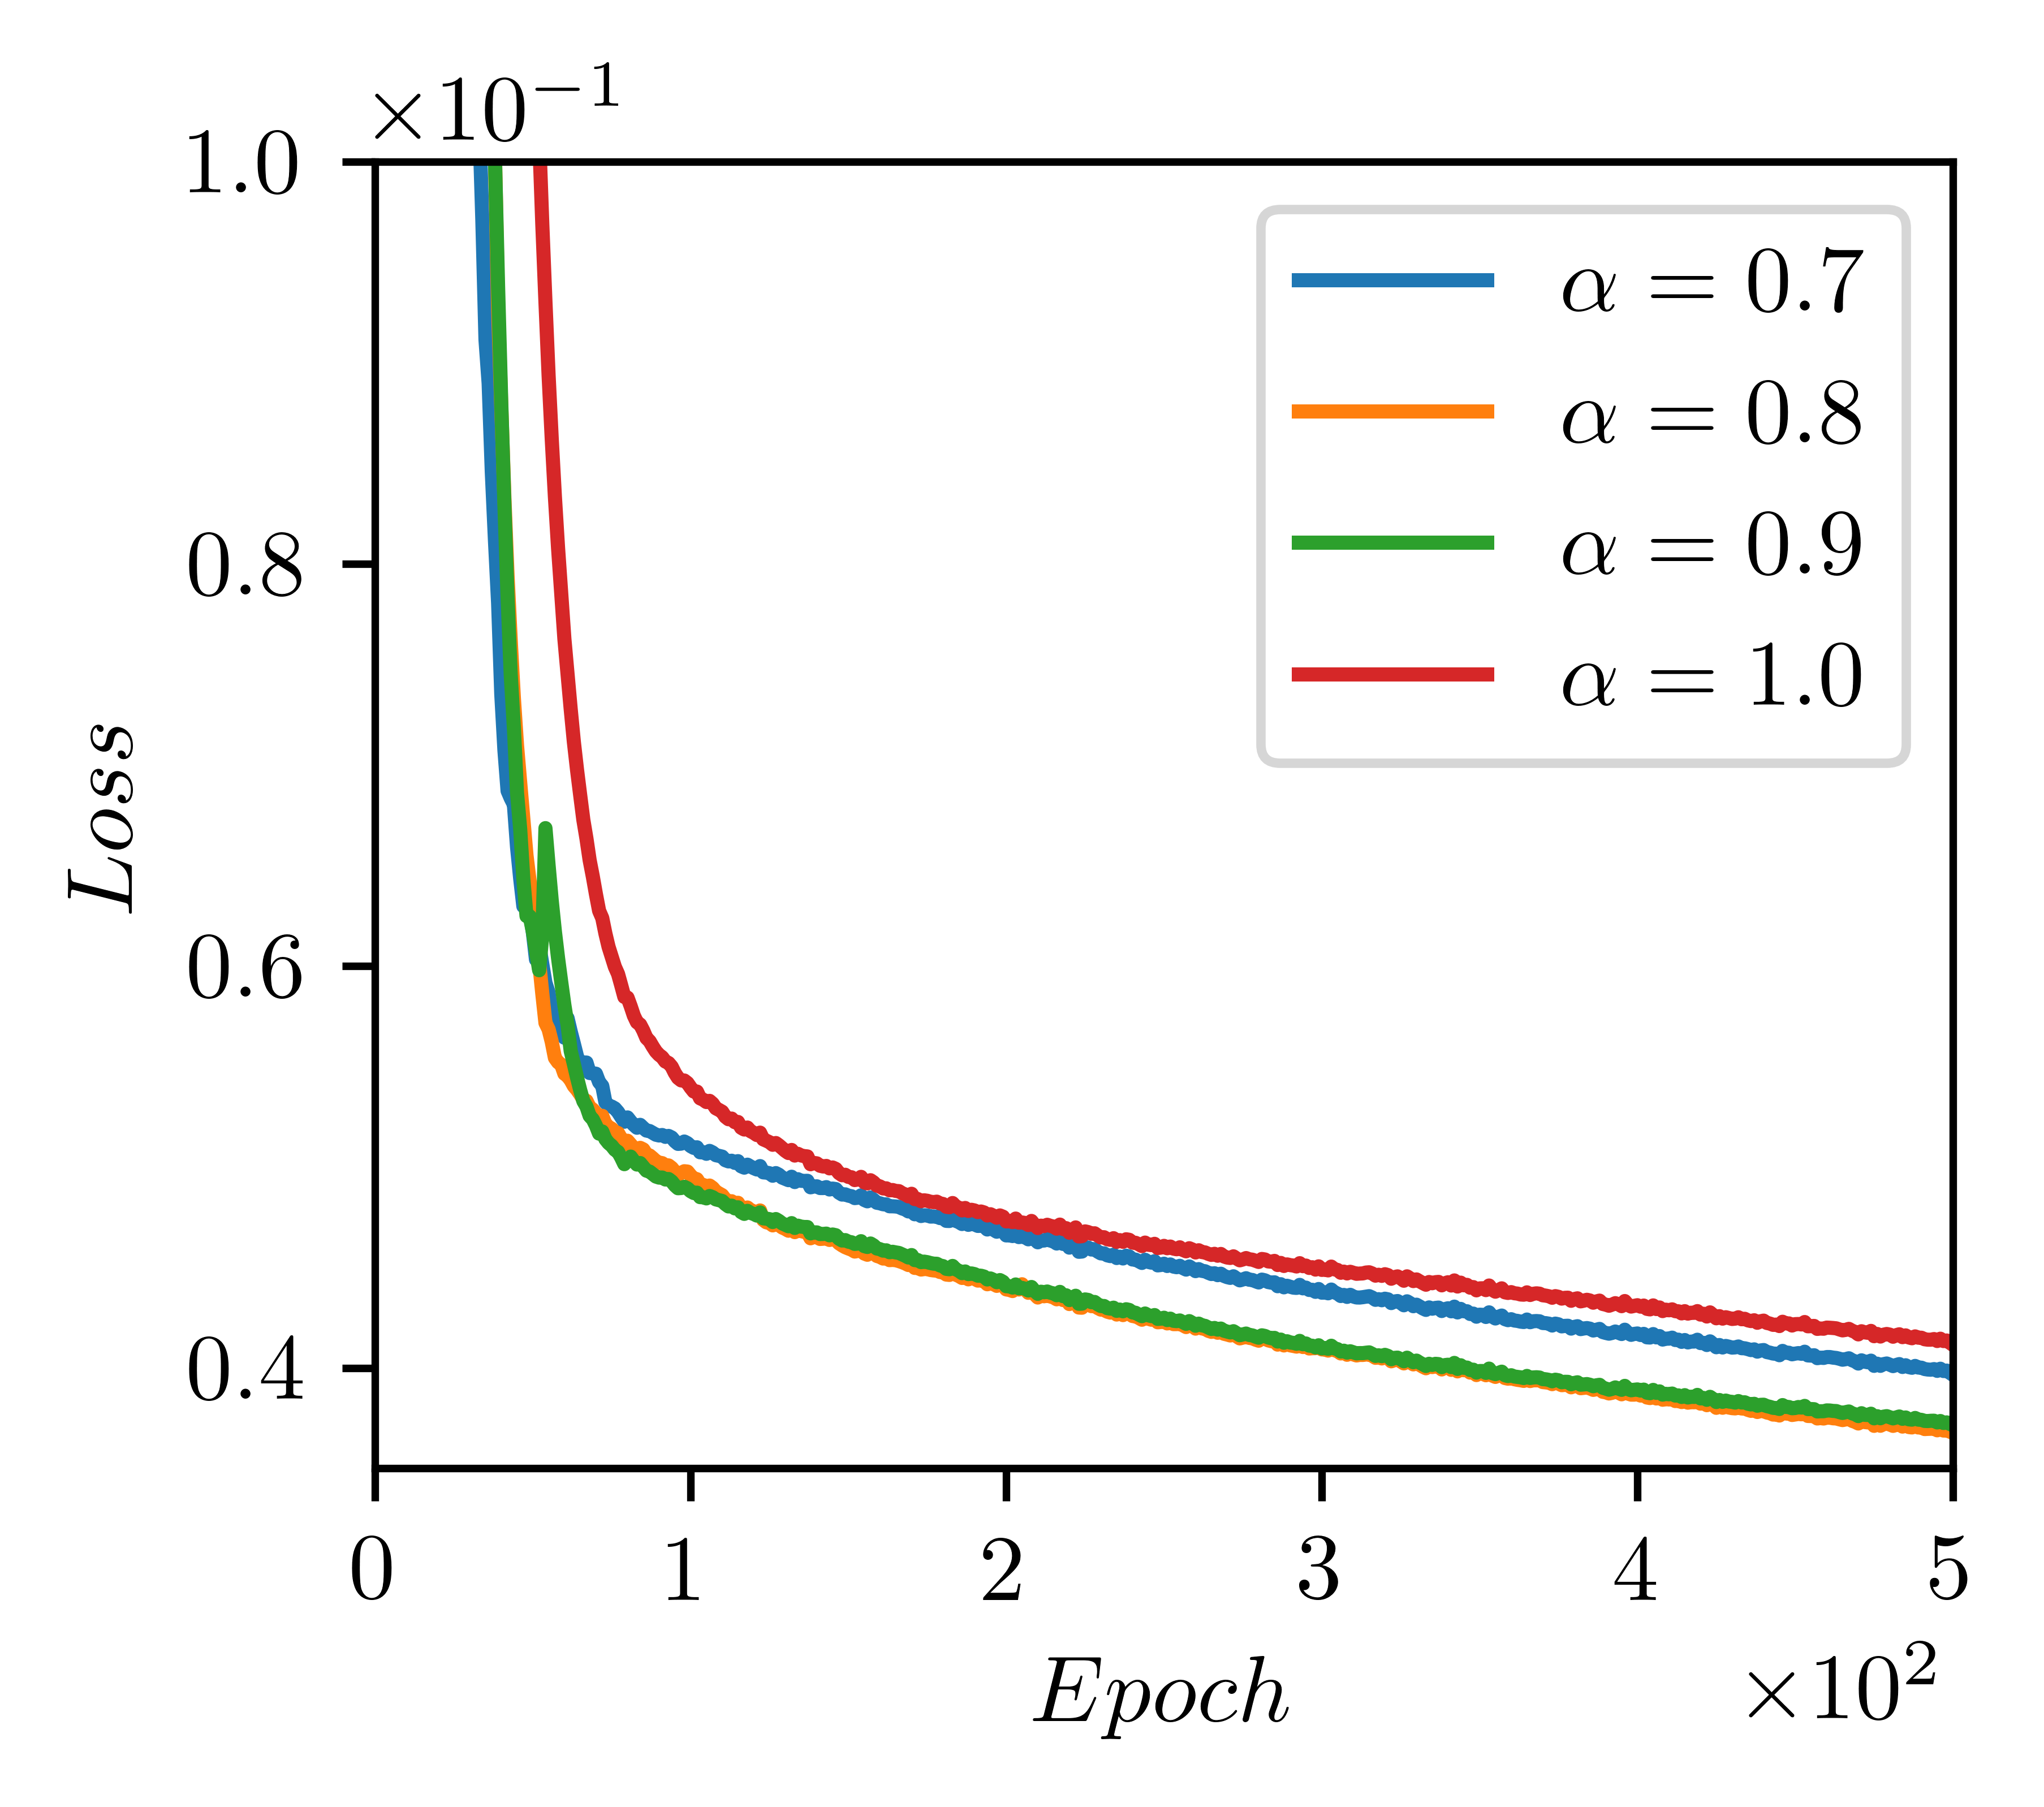

In [543]:
plt.figure(figsize=(3,2.5),dpi=1200)
plt.plot(train_loss07,label=r'$\alpha=0.7$')
plt.plot(train_loss08,label=r'$\alpha=0.8$')
plt.plot(train_loss09,label=r'$\alpha=0.9$')
plt.plot(train_loss10,label=r'$\alpha=1.0$')
plt.xlim(0,500)
plt.ylim(0.035,0.1)
plt.ticklabel_format(axis='both', style='sci', scilimits=(2, 6))
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.legend()
plt.savefig('picture/fig5/Fig5(a1)'+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig5/Fig5(a1)'+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()

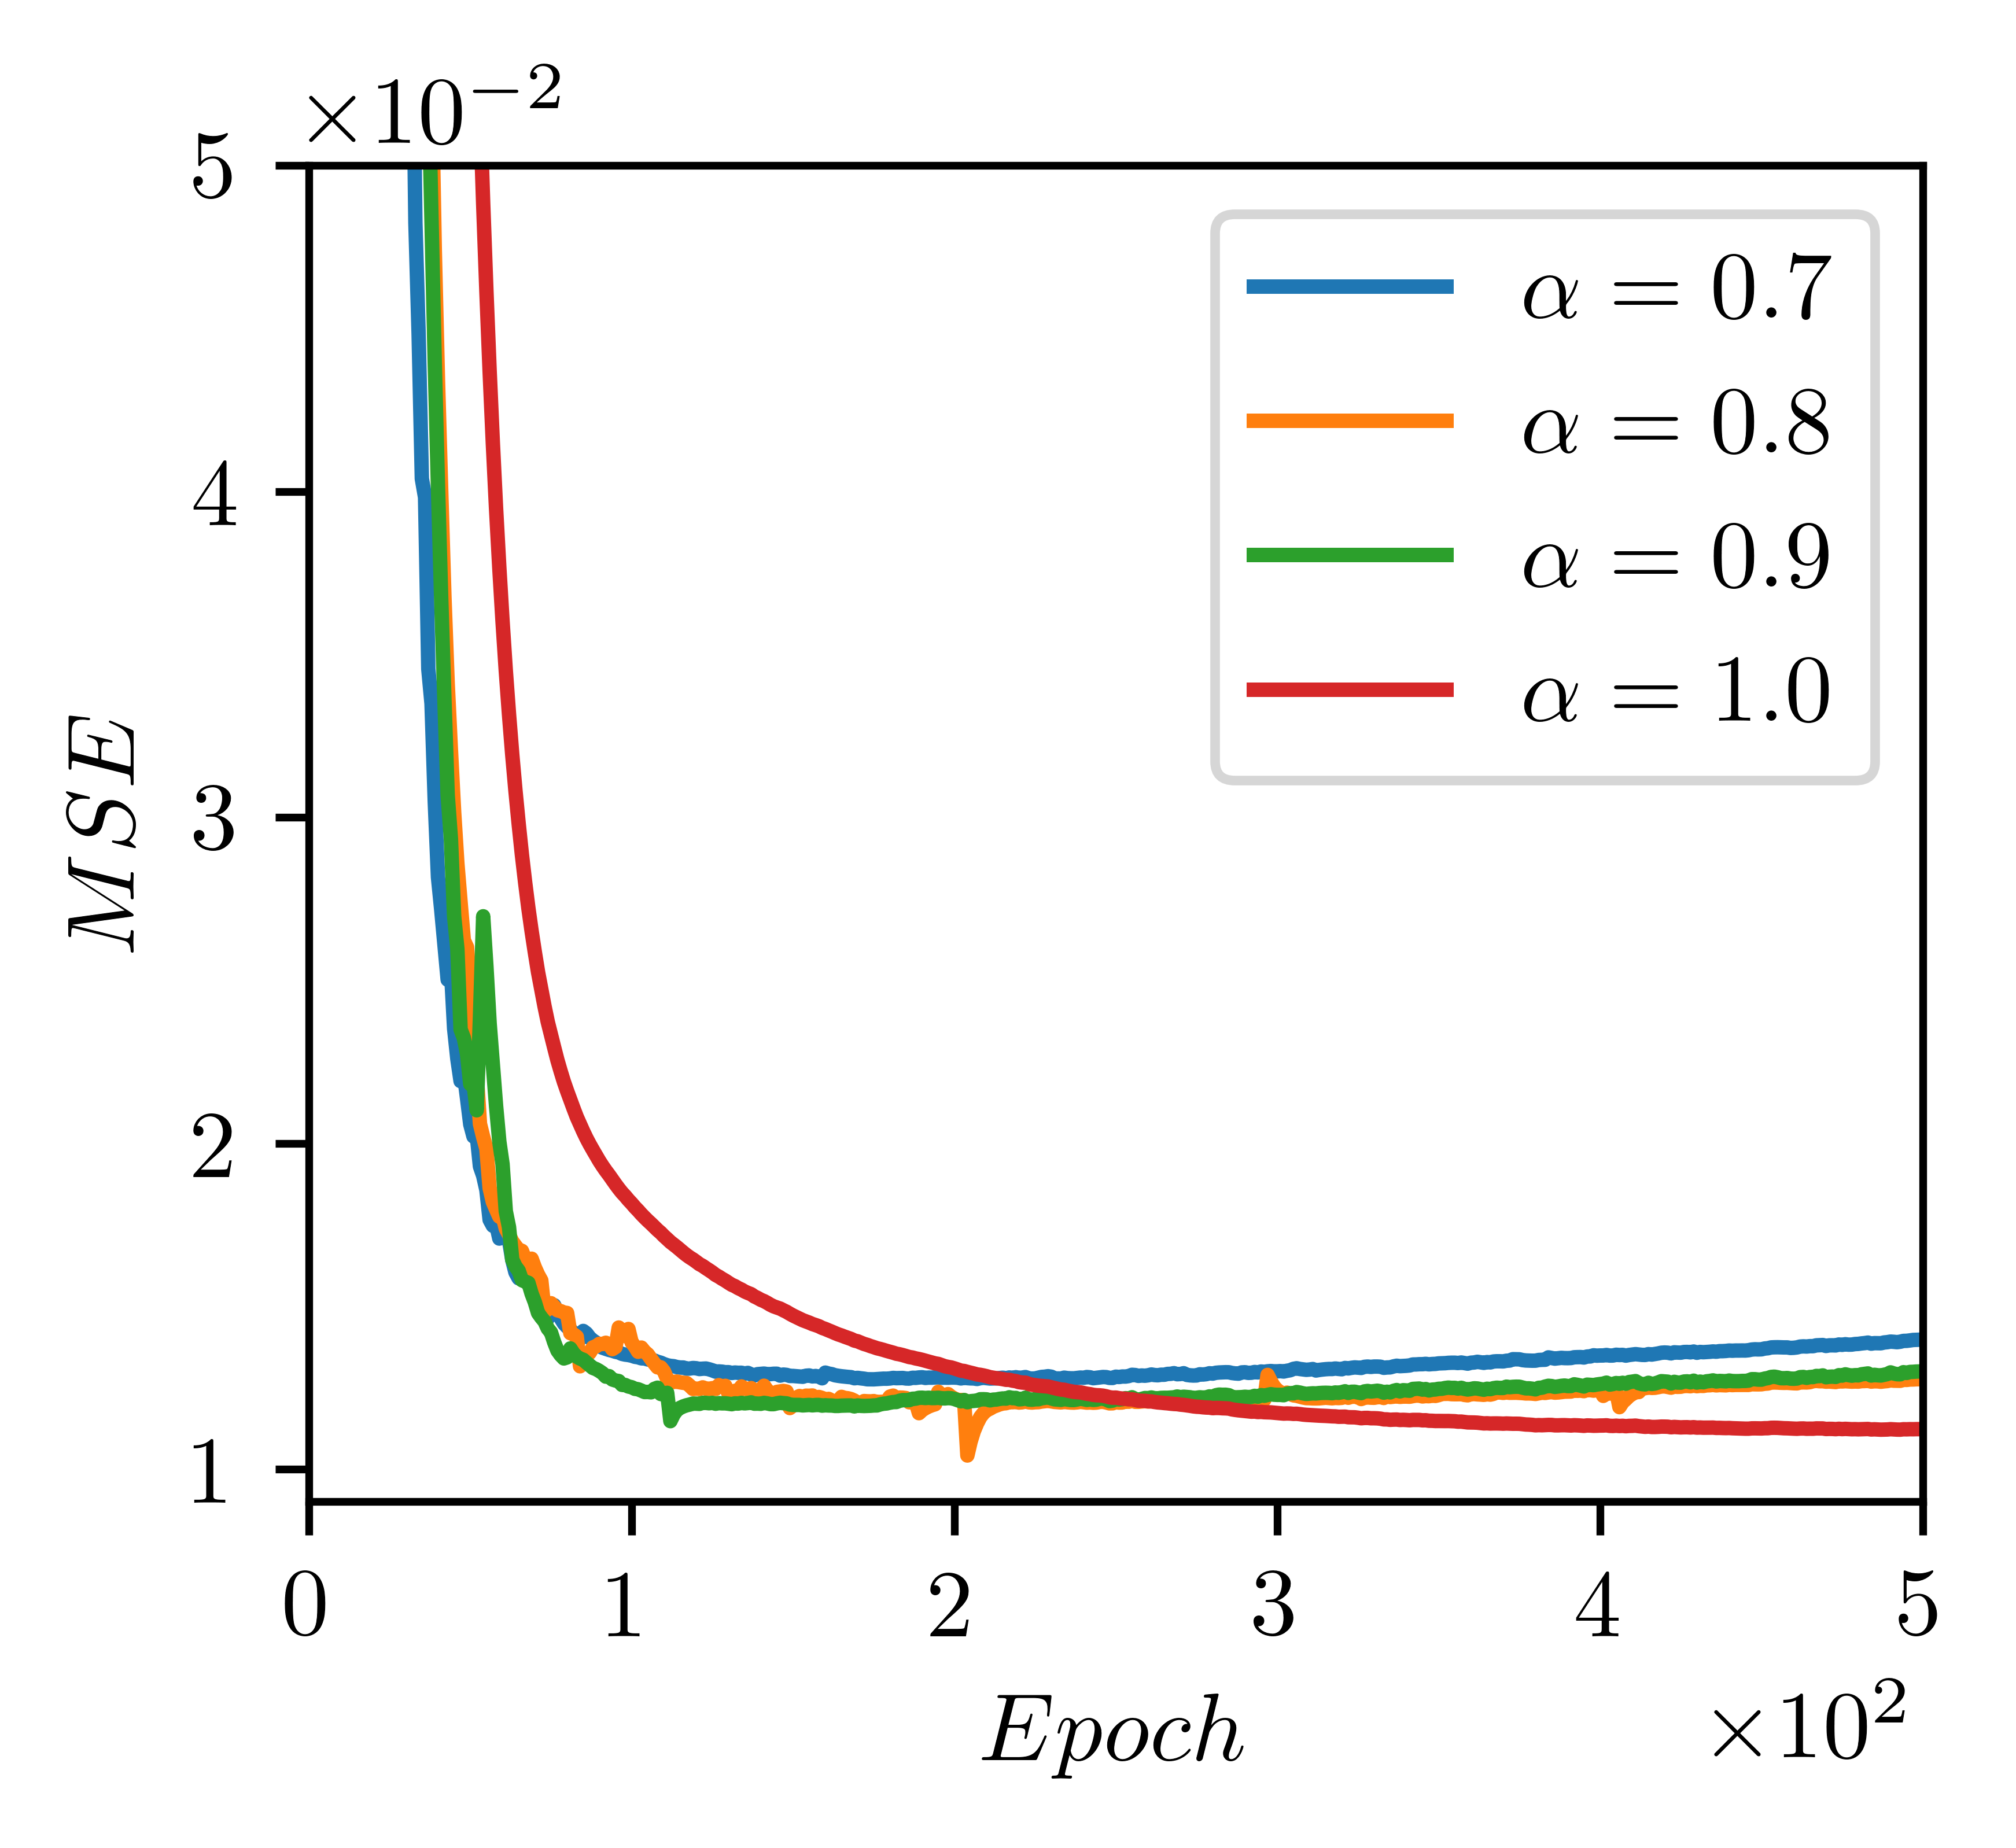

In [552]:
plt.figure(figsize=(3,2.5),dpi=1200)
plt.plot(val_loss07,label=r'$\alpha=0.7$')
plt.plot(val_loss08,label=r'$\alpha=0.8$')
plt.plot(val_loss09,label=r'$\alpha=0.9$')
plt.plot(val_loss10,label=r'$\alpha=1.0$')
plt.xlim(0,500)
plt.ylim(0.009,0.05)
plt.ticklabel_format(axis='both', style='sci', scilimits=(2, 6))
plt.xlabel('$Epoch$')
plt.ylabel('$MSE$')
plt.legend()
plt.savefig('picture/fig5/Fig5(a2)'+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig5/Fig5(a2)'+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()

In [553]:
model.load_state_dict(torch.load('./model/fig5/'+stock+'_model_fractional_1.0_0.04_.pth'))  ##
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
RMSE10 = RMSE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
MAE10 = MAE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
print(f'RMSE:{RMSE10:.6f}')
print(f'MAE:{MAE10:.6f}')

RMSE:0.185480
MAE:0.154119


In [554]:
model.load_state_dict(torch.load('./model/fig5/'+stock+'_model_fractional_0.9_0.04_.pth'))  ##
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
RMSE09 = RMSE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
MAE09 = MAE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
print(f'RMSE:{RMSE09:.6f}')
print(f'MAE:{MAE09:.6f}')

RMSE:0.182397
MAE:0.153016


In [556]:
model.load_state_dict(torch.load('./model/fig5/'+stock+'_model_fractional_0.8_0.04_.pth'))  ##
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
RMSE08 = RMSE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
MAE08 = MAE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
print(f'RMSE:{RMSE08:.6f}')
print(f'MAE:{MAE08:.6f}')

RMSE:0.180793
MAE:0.151614


In [557]:
model.load_state_dict(torch.load('./model/fig5/'+stock+'_model_fractional_0.7_0.04_.pth'))  ##
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
RMSE07 = RMSE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
MAE07 = MAE(y_test.cpu().numpy(),test_outputs.cpu().detach().numpy())
print(f'RMSE:{RMSE07:.6f}')
print(f'MAE:{MAE07:.6f}')

RMSE:0.189683
MAE:0.159380


In [558]:
RMSE_ETTh1 = [0.189683, 0.180793, 0.182397, 0.185480]    ####MSE_DJI,MAE_DJI
MAE_ETTh1 = [0.159380, 0.151614, 0.153016, 0.154119]
x = [0.7,0.8,0.9,1.0]

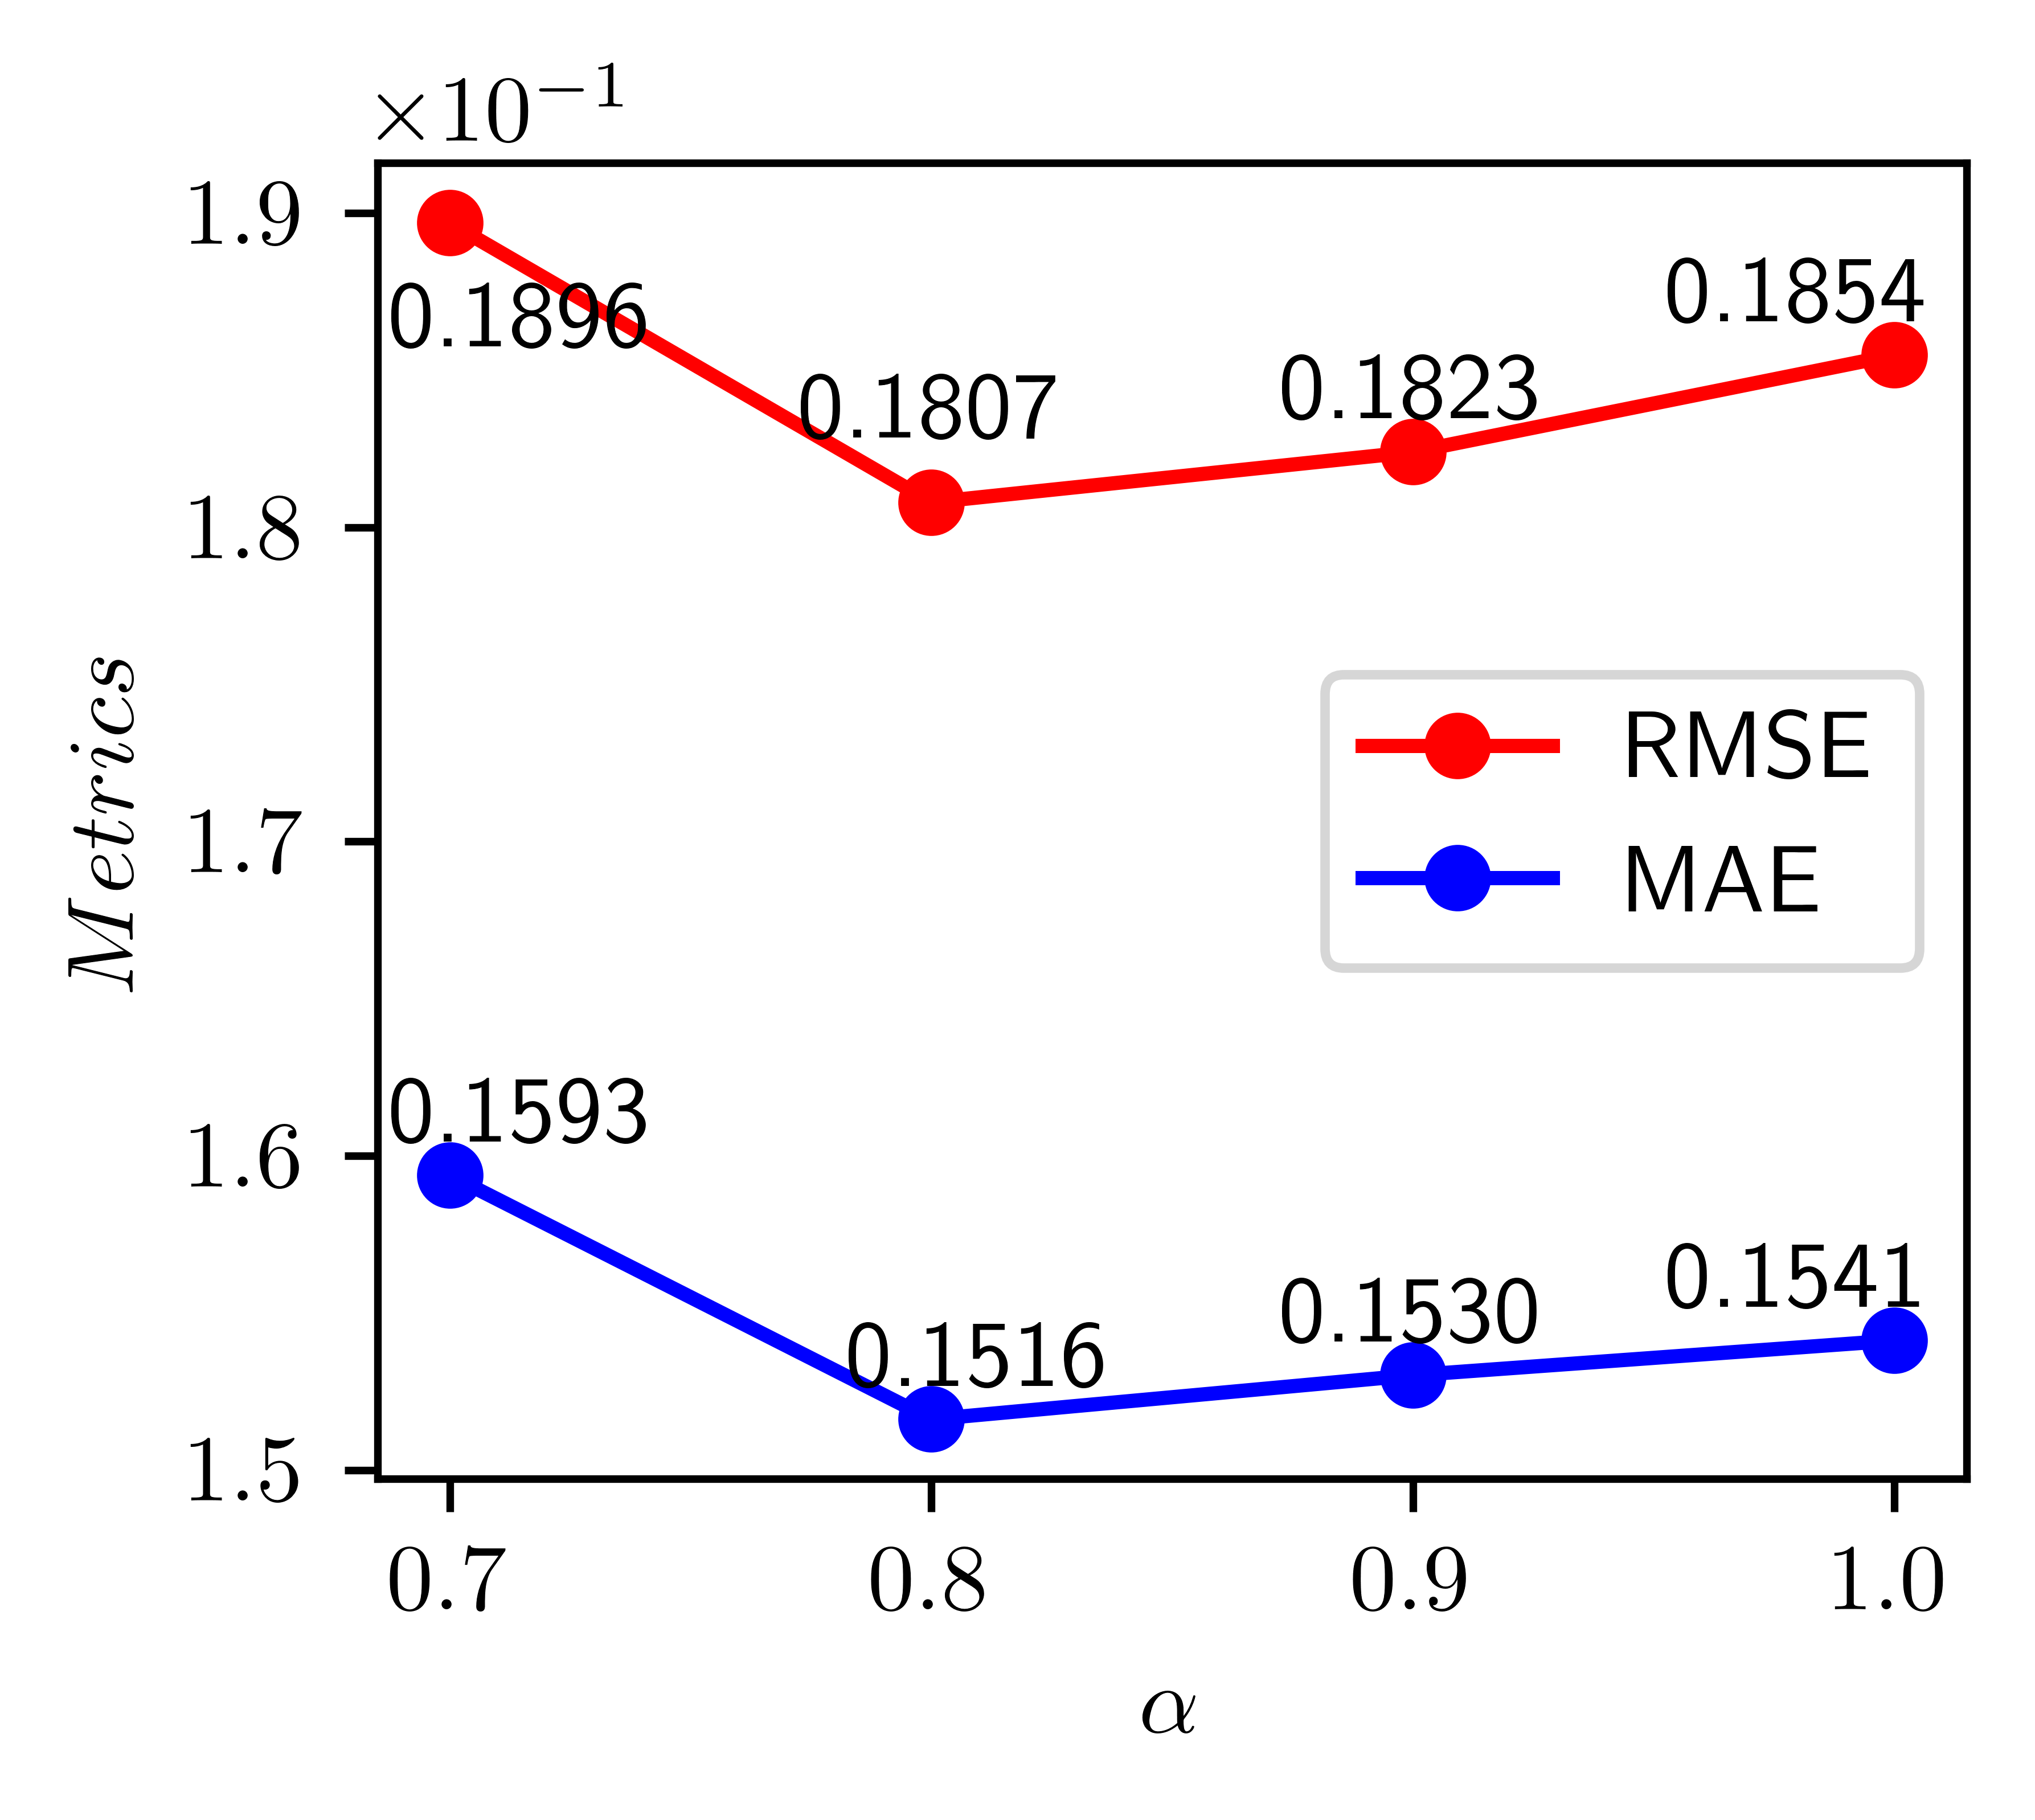

In [565]:
plt.figure(figsize=(3,2.5),dpi=1200)

plt.plot(x,RMSE_ETTh1,'o-',c='r',label=r'RMSE')
plt.plot(x,MAE_ETTh1,'o-',c='b',label=r'MAE')

plt.text(0.715, 0.185683, f'0.1896', ha='center')
plt.text(0.8, 0.182793, f'0.1807', ha='center')
plt.text(0.9, 0.183397, f'0.1823', ha='center')
plt.text(0.98, 0.186480, f'0.1854', ha='center')

plt.text(0.715, 0.160380, f'0.1593', ha='center')
plt.text(0.81, 0.152614, f'0.1516', ha='center')
plt.text(0.9, 0.154016, f'0.1530', ha='center')
plt.text(0.98, 0.155119, f'0.1541', ha='center')

plt.xticks(x)
plt.ticklabel_format(axis='both', style='sci', scilimits=(2, 6))
plt.ylabel('$Metrics$')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.savefig('picture/fig5/Fig5(a3)'+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig5/Fig5(a3)'+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()